<a href="https://colab.research.google.com/github/tabba98/neural-network/blob/main/VoxNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
!pip install torchmetrics
from torchmetrics.classification import Accuracy
from torchmetrics import ConfusionMatrix

!pip install open3d;
import open3d as o3d

#for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

import scipy
from scipy.ndimage import rotate

import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 6.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.5/422.5 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.6 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.7.1
    Uninstalling nbformat-5.7.1:
      Successfully uninstalled nbformat-5.7.1


In [2]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

--2023-01-22 11:54:07--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.74
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip [following]
--2023-01-22 11:54:07--  https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M   107MB/s    in 4.3s    

2023-01-22 11:54:12 (105 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]



In [3]:
!unzip -q ModelNet10.zip;

In [4]:
import os
ROOT = '/content/ModelNet10/'
CLASSES = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']

X = {'train': [], 'test': []}
Y = {'train': [], 'test': []}
for label, cl in enumerate(CLASSES):
    for split in ['train', 'test']:
        examples_dir = os.path.join(ROOT, cl, split)
        for example in os.listdir(examples_dir):
          voxel_index = []
          if 'off' in example:
            mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
            mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
            voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
            
            X[split].append(voxel_grid)
            Y[split].append(label)


In [5]:
class VoxelDataset2(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X['train']
          self.label = Y['train']
      else:
          self.data = X['test']
          self.label = Y['test']
        
                
    def __len__(self):
        return len(self.label)

    def __preproc__(self, voxels):
        
        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1

        #flip x
        if np.random.randint(2):
            vox_g = np.flip(vox_g, axis=0)
        
        #flip y
        if np.random.randint(2):
            vox_g = np.flip(vox_g, axis=1)
        
        angle = 360 * np.random.random_sample(1)[0]
        vox_g = rotate(vox_g, axes=(0, 1), angle=angle, cval=0.0, reshape=False)  
        
        return vox_g.copy()

    def __getitem__(self, idx):
        label = self.label[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label

In [6]:
from collections import OrderedDict
class VoxNet(nn.Module):
    def __init__(self):
        super(VoxNet, self).__init__()
        n_classes = 10
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('relu1', torch.nn.ReLU()),
            #('batch1', torch.nn.BatchNorm3d(32)),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3)),
            ('relu2', torch.nn.ReLU()),
            #('batch2', torch.nn.BatchNorm3d(32)),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        return x


In [7]:
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm

def blue(x): return '\033[94m' + x + '\033[0m'

train_ds = VoxelDataset2(train=True)
test_ds = VoxelDataset2(train=False)
train_dataloader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(dataset=test_ds, batch_size=32)

pred_conf, y_conf = [], []                                                           

train_loss_history, valid_loss_history = [], []
train_acc_history, valid_acc_history = [], []
train_accuracy = Accuracy(task='multiclass', num_classes=10)
valid_accuracy = Accuracy(task='multiclass', num_classes=10)

model = VoxNet()
opt = SGD(model.parameters(), lr=1e-2, weight_decay = 0)
loss_fn = F.cross_entropy
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
epochs = 100
best_val = np.inf

num_batch = len(train_ds) / 32
print(num_batch)

total_time = time.time()

for epoch in range(epochs):
    t = time.time()

    temp_correct = 0
    temp_testset = 0
    temp_correct_test = 0
    temp_testset_test = 0
    train_loss = []                                                         #track training loss
    test_loss = []
    model.train()
    iterator = tqdm(enumerate(train_dataloader, 0))
    for i, data in iterator:
        inputs, labels = data[0], data[1]
        inputs = inputs.to(device)
        labels = labels.to(device)

        opt.zero_grad()
        pred = model(inputs)  # torch.Size([256, 10])
        loss = F.cross_entropy(pred,labels)
        train_loss.append(loss.cpu().data)
        train_accuracy.update(torch.argmax(pred, 1).cpu(), labels.cpu()) 

        loss.backward()
        opt.step()
        iterator.set_description(f"Train loss: {loss.cpu().data}")
        
        pred_choice = pred.data.max(1)[1]
        correct = pred_choice.eq(labels.data).cpu().sum()
        
        temp_correct += correct.item()
        temp_testset += inputs.size()[0]

    
    with torch.no_grad():
      model.eval()
      for j, sample in tqdm(enumerate(test_dataloader, 0)):    
          inputs_test, labels_test = sample[0], sample[1]
          inputs_test = inputs_test.to(device)
          labels_test = labels_test.to(device)
          inputs_test = inputs_test.float()  # 转float, torch.Size([256, 1, 32, 32, 32])
          
          pred_test = model(inputs_test)
          loss_test = F.cross_entropy(pred_test, labels_test)
          test_loss.append(loss_test.cpu().data)
          valid_accuracy.update(torch.argmax(pred_test, 1).cpu(), labels_test.cpu())
          pred_choice_test = pred_test.data.max(1)[1]

          correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
          pred_conf.append(torch.argmax(pred_test, 1))
          y_conf.append(labels_test)
          
          temp_correct_test += correct_test.item()
          temp_testset_test += inputs_test.size()[0]

    #compute confusion matrix
    a = torch.cat(pred_conf).cpu()
    b = torch.cat(y_conf).cpu()
    confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
    conf_matrix = confmat(a, b)
    conf_matrix = torch.round(conf_matrix, decimals=2)

    # total accuracy over all batches
    total_train_accuracy = train_accuracy.compute()
    total_valid_accuracy = valid_accuracy.compute()
    train_accuracy.reset()
    valid_accuracy.reset()
           
    #track loss and acc for plotting
    train_loss_history.append(torch.mean(torch.tensor(train_loss)))
    valid_loss_history.append(torch.mean(torch.tensor(test_loss)))
    train_acc_history.append(total_train_accuracy)
    valid_acc_history.append(total_valid_accuracy)
    history = {"train_loss": torch.tensor(train_loss_history), "train_acc": torch.tensor(train_acc_history), 
               "test_loss": torch.tensor(valid_loss_history), "test_acc": torch.tensor(valid_acc_history)}

    elapsed_time_epoch = time.time() - t
    tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, epochs)
    tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
    tmp2 = "train-loss: {:4.2f}, train-acc: {:.2%}".format(train_loss_history[epoch], train_acc_history[epoch].item())
    tmp3 = "valid-loss: {:4.2f}, valid-acc: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history[epoch].item())
    print(tmp0, tmp1, tmp2, tmp3, sep="\n")           
    
    #print("epoch %d: train accuracy %f" % (epoch, temp_correct / float(temp_testset)))
    #print("epoch %d: test accuracy %f" % (epoch+1, temp_correct_test / float(temp_testset_test)))

    


total_correct = 0
total_testset = 0

model.eval()
for i, data in tqdm(enumerate(test_dataloader, 0)):
    inputs, labels = data[0], data[1]
    inputs = inputs.to(device)
    labels = labels.to(device)
    inputs = inputs.float()  # 转float, torch.Size([256, 1, 32, 32, 32])

    
    pred = model(inputs)
    pred_choice = pred.data.max(1)[1]
    correct = pred_choice.eq(labels.data).cpu().sum()
    total_correct += correct.item()
    total_testset += inputs.size()[0]

print("final accuracy {}".format(total_correct / float(total_testset)))



124.71875


Train loss: 2.026557683944702: : 124it [01:19,  1.56it/s]
29it [00:10,  2.82it/s]


epoch:  1 /100
time: 89.82 seconds
train-loss: 2.21, train-acc: 21.50%
valid-loss: 2.27, valid-acc: 22.58%



Train loss: 1.619508981704712: : 124it [01:19,  1.57it/s]
29it [00:10,  2.79it/s]


epoch:  2 /100
time: 89.54 seconds
train-loss: 1.81, train-acc: 41.86%
valid-loss: 1.80, valid-acc: 38.77%



Train loss: 1.5174211263656616: : 124it [01:19,  1.57it/s]
29it [00:10,  2.81it/s]


epoch:  3 /100
time: 89.54 seconds
train-loss: 1.49, train-acc: 51.41%
valid-loss: 1.63, valid-acc: 39.43%



Train loss: 1.1745524406433105: : 124it [01:18,  1.57it/s]
29it [00:10,  2.83it/s]


epoch:  4 /100
time: 89.26 seconds
train-loss: 1.32, train-acc: 55.80%
valid-loss: 1.38, valid-acc: 51.54%



Train loss: 1.1341745853424072: : 124it [01:19,  1.57it/s]
29it [00:10,  2.81it/s]


epoch:  5 /100
time: 89.55 seconds
train-loss: 1.20, train-acc: 59.68%
valid-loss: 1.31, valid-acc: 50.88%



Train loss: 1.0243195295333862: : 124it [01:19,  1.56it/s]
29it [00:10,  2.83it/s]


epoch:  6 /100
time: 89.56 seconds
train-loss: 1.12, train-acc: 61.27%
valid-loss: 1.15, valid-acc: 59.25%



Train loss: 0.9171352982521057: : 124it [01:19,  1.57it/s]
29it [00:10,  2.82it/s]


epoch:  7 /100
time: 89.30 seconds
train-loss: 1.05, train-acc: 63.26%
valid-loss: 1.15, valid-acc: 58.92%



Train loss: 1.1325923204421997: : 124it [01:18,  1.57it/s]
29it [00:10,  2.84it/s]


epoch:  8 /100
time: 89.04 seconds
train-loss: 1.02, train-acc: 65.10%
valid-loss: 1.10, valid-acc: 60.24%



Train loss: 0.9798476099967957: : 124it [01:18,  1.58it/s]
29it [00:10,  2.84it/s]


epoch:  9 /100
time: 88.90 seconds
train-loss: 1.00, train-acc: 65.85%
valid-loss: 1.11, valid-acc: 60.57%



Train loss: 1.1301872730255127: : 124it [01:18,  1.57it/s]
29it [00:10,  2.83it/s]


epoch: 10 /100
time: 89.24 seconds
train-loss: 0.99, train-acc: 65.17%
valid-loss: 1.07, valid-acc: 62.44%



Train loss: 0.7483451962471008: : 124it [01:18,  1.57it/s]
29it [00:10,  2.79it/s]


epoch: 11 /100
time: 89.31 seconds
train-loss: 0.95, train-acc: 67.06%
valid-loss: 1.05, valid-acc: 62.33%



Train loss: 0.8933073282241821: : 124it [01:19,  1.56it/s]
29it [00:10,  2.80it/s]


epoch: 12 /100
time: 89.68 seconds
train-loss: 0.94, train-acc: 67.04%
valid-loss: 1.05, valid-acc: 64.65%



Train loss: 1.0196353197097778: : 124it [01:18,  1.57it/s]
29it [00:10,  2.79it/s]


epoch: 13 /100
time: 89.43 seconds
train-loss: 0.91, train-acc: 68.88%
valid-loss: 1.01, valid-acc: 64.54%



Train loss: 0.7418619394302368: : 124it [01:19,  1.56it/s]
29it [00:10,  2.81it/s]


epoch: 14 /100
time: 89.68 seconds
train-loss: 0.92, train-acc: 67.72%
valid-loss: 0.99, valid-acc: 66.52%



Train loss: 0.758653998374939: : 124it [01:19,  1.57it/s]
29it [00:10,  2.81it/s]


epoch: 15 /100
time: 89.51 seconds
train-loss: 0.88, train-acc: 69.41%
valid-loss: 0.93, valid-acc: 68.28%



Train loss: 1.1442896127700806: : 124it [01:19,  1.56it/s]
29it [00:10,  2.80it/s]


epoch: 16 /100
time: 89.69 seconds
train-loss: 0.87, train-acc: 69.43%
valid-loss: 0.98, valid-acc: 66.63%



Train loss: 1.0217769145965576: : 124it [01:19,  1.57it/s]
29it [00:10,  2.81it/s]


epoch: 17 /100
time: 89.51 seconds
train-loss: 0.85, train-acc: 70.36%
valid-loss: 0.94, valid-acc: 68.72%



Train loss: 0.5884907245635986: : 124it [01:19,  1.57it/s]
29it [00:10,  2.81it/s]


epoch: 18 /100
time: 89.53 seconds
train-loss: 0.85, train-acc: 70.39%
valid-loss: 0.94, valid-acc: 65.53%



Train loss: 0.6925227642059326: : 124it [01:18,  1.57it/s]
29it [00:10,  2.83it/s]


epoch: 19 /100
time: 89.01 seconds
train-loss: 0.81, train-acc: 72.18%
valid-loss: 0.88, valid-acc: 69.16%



Train loss: 0.7020254731178284: : 124it [01:18,  1.57it/s]
29it [00:10,  2.82it/s]


epoch: 20 /100
time: 89.09 seconds
train-loss: 0.83, train-acc: 70.54%
valid-loss: 0.87, valid-acc: 69.49%



Train loss: 0.9942561984062195: : 124it [01:21,  1.53it/s]
29it [00:10,  2.83it/s]


epoch: 21 /100
time: 91.32 seconds
train-loss: 0.82, train-acc: 72.58%
valid-loss: 0.89, valid-acc: 68.17%



Train loss: 0.863102912902832: : 124it [01:19,  1.57it/s]
29it [00:10,  2.81it/s]


epoch: 22 /100
time: 89.50 seconds
train-loss: 0.80, train-acc: 73.26%
valid-loss: 0.85, valid-acc: 69.27%



Train loss: 0.9609313607215881: : 124it [01:19,  1.56it/s]
29it [00:10,  2.81it/s]


epoch: 23 /100
time: 89.81 seconds
train-loss: 0.78, train-acc: 74.07%
valid-loss: 0.83, valid-acc: 71.37%



Train loss: 0.7038715481758118: : 124it [01:19,  1.57it/s]
29it [00:10,  2.80it/s]


epoch: 24 /100
time: 89.39 seconds
train-loss: 0.76, train-acc: 73.92%
valid-loss: 0.85, valid-acc: 70.15%



Train loss: 0.72635817527771: : 124it [01:19,  1.56it/s]
29it [00:10,  2.83it/s]


epoch: 25 /100
time: 89.59 seconds
train-loss: 0.74, train-acc: 74.40%
valid-loss: 0.82, valid-acc: 71.81%



Train loss: 0.8211084008216858: : 124it [01:19,  1.56it/s]
29it [00:10,  2.79it/s]


epoch: 26 /100
time: 89.96 seconds
train-loss: 0.72, train-acc: 75.13%
valid-loss: 0.82, valid-acc: 71.59%



Train loss: 0.7766476273536682: : 124it [01:19,  1.55it/s]
29it [00:10,  2.78it/s]


epoch: 27 /100
time: 90.21 seconds
train-loss: 0.73, train-acc: 74.40%
valid-loss: 0.81, valid-acc: 72.58%



Train loss: 0.6669003367424011: : 124it [01:19,  1.57it/s]
29it [00:10,  2.80it/s]


epoch: 28 /100
time: 89.51 seconds
train-loss: 0.71, train-acc: 76.06%
valid-loss: 0.82, valid-acc: 72.69%



Train loss: 0.9096843600273132: : 124it [01:21,  1.52it/s]
29it [00:10,  2.80it/s]


epoch: 29 /100
time: 91.76 seconds
train-loss: 0.70, train-acc: 76.11%
valid-loss: 0.76, valid-acc: 74.01%



Train loss: 0.8210710883140564: : 124it [01:19,  1.56it/s]
29it [00:10,  2.82it/s]


epoch: 30 /100
time: 89.65 seconds
train-loss: 0.69, train-acc: 77.09%
valid-loss: 0.76, valid-acc: 74.56%



Train loss: 0.6366649270057678: : 124it [01:18,  1.57it/s]
29it [00:10,  2.83it/s]


epoch: 31 /100
time: 89.12 seconds
train-loss: 0.68, train-acc: 76.89%
valid-loss: 0.78, valid-acc: 73.68%



Train loss: 0.6743038892745972: : 124it [01:19,  1.57it/s]
29it [00:10,  2.82it/s]


epoch: 32 /100
time: 89.52 seconds
train-loss: 0.67, train-acc: 76.71%
valid-loss: 0.78, valid-acc: 72.69%



Train loss: 0.5684832334518433: : 124it [01:18,  1.58it/s]
29it [00:10,  2.83it/s]


epoch: 33 /100
time: 88.92 seconds
train-loss: 0.65, train-acc: 77.80%
valid-loss: 0.75, valid-acc: 74.45%



Train loss: 0.642572820186615: : 124it [01:18,  1.57it/s]
29it [00:10,  2.83it/s]


epoch: 34 /100
time: 89.26 seconds
train-loss: 0.65, train-acc: 77.70%
valid-loss: 0.75, valid-acc: 75.55%



Train loss: 0.639185905456543: : 124it [01:18,  1.57it/s]
29it [00:10,  2.78it/s]


epoch: 35 /100
time: 89.42 seconds
train-loss: 0.64, train-acc: 78.20%
valid-loss: 0.73, valid-acc: 75.22%



Train loss: 0.6894358992576599: : 124it [01:20,  1.53it/s]
29it [00:10,  2.82it/s]


epoch: 36 /100
time: 91.26 seconds
train-loss: 0.64, train-acc: 77.85%
valid-loss: 0.72, valid-acc: 76.87%



Train loss: 0.7286120653152466: : 124it [01:19,  1.56it/s]
29it [00:10,  2.81it/s]


epoch: 37 /100
time: 89.82 seconds
train-loss: 0.63, train-acc: 79.06%
valid-loss: 0.74, valid-acc: 73.90%



Train loss: 0.5990538597106934: : 124it [01:19,  1.56it/s]
29it [00:10,  2.80it/s]


epoch: 38 /100
time: 89.79 seconds
train-loss: 0.63, train-acc: 78.63%
valid-loss: 0.72, valid-acc: 76.32%



Train loss: 0.8985694050788879: : 124it [01:19,  1.56it/s]
29it [00:10,  2.79it/s]


epoch: 39 /100
time: 89.90 seconds
train-loss: 0.62, train-acc: 78.76%
valid-loss: 0.71, valid-acc: 75.55%



Train loss: 0.6839163303375244: : 124it [01:19,  1.57it/s]
29it [00:10,  2.83it/s]


epoch: 40 /100
time: 89.32 seconds
train-loss: 0.60, train-acc: 79.79%
valid-loss: 0.71, valid-acc: 75.33%



Train loss: 0.6609004139900208: : 124it [01:18,  1.58it/s]
29it [00:10,  2.84it/s]


epoch: 41 /100
time: 88.79 seconds
train-loss: 0.61, train-acc: 79.69%
valid-loss: 0.71, valid-acc: 76.98%



Train loss: 0.28142425417900085: : 124it [01:18,  1.58it/s]
29it [00:10,  2.84it/s]


epoch: 42 /100
time: 88.62 seconds
train-loss: 0.60, train-acc: 79.74%
valid-loss: 0.73, valid-acc: 75.55%



Train loss: 0.7344471216201782: : 124it [01:18,  1.58it/s]
29it [00:10,  2.81it/s]


epoch: 43 /100
time: 88.85 seconds
train-loss: 0.58, train-acc: 80.85%
valid-loss: 0.66, valid-acc: 76.98%



Train loss: 0.6948176026344299: : 124it [01:18,  1.58it/s]
29it [00:10,  2.84it/s]


epoch: 44 /100
time: 88.85 seconds
train-loss: 0.57, train-acc: 81.20%
valid-loss: 0.69, valid-acc: 75.77%



Train loss: 0.5681698322296143: : 124it [01:18,  1.58it/s]
29it [00:10,  2.85it/s]


epoch: 45 /100
time: 88.68 seconds
train-loss: 0.57, train-acc: 80.49%
valid-loss: 0.67, valid-acc: 77.86%



Train loss: 0.4964986741542816: : 124it [01:18,  1.58it/s]
29it [00:10,  2.81it/s]


epoch: 46 /100
time: 88.97 seconds
train-loss: 0.58, train-acc: 79.59%
valid-loss: 0.64, valid-acc: 78.85%



Train loss: 0.7344740033149719: : 124it [01:18,  1.58it/s]
29it [00:10,  2.82it/s]


epoch: 47 /100
time: 88.86 seconds
train-loss: 0.57, train-acc: 80.44%
valid-loss: 0.67, valid-acc: 76.76%



Train loss: 0.8760404586791992: : 124it [01:18,  1.58it/s]
29it [00:10,  2.84it/s]


epoch: 48 /100
time: 88.61 seconds
train-loss: 0.57, train-acc: 81.00%
valid-loss: 0.68, valid-acc: 76.21%



Train loss: 0.3496837317943573: : 124it [01:18,  1.58it/s]
29it [00:10,  2.85it/s]


epoch: 49 /100
time: 88.65 seconds
train-loss: 0.55, train-acc: 81.17%
valid-loss: 0.69, valid-acc: 77.53%



Train loss: 0.3721955120563507: : 124it [01:18,  1.58it/s]
29it [00:10,  2.78it/s]


epoch: 50 /100
time: 88.99 seconds
train-loss: 0.54, train-acc: 81.68%
valid-loss: 0.66, valid-acc: 77.75%



Train loss: 0.5998406410217285: : 124it [01:18,  1.58it/s]
29it [00:10,  2.83it/s]


epoch: 51 /100
time: 88.70 seconds
train-loss: 0.55, train-acc: 82.26%
valid-loss: 0.65, valid-acc: 77.97%



Train loss: 0.2674623727798462: : 124it [01:19,  1.57it/s]
29it [00:10,  2.79it/s]


epoch: 52 /100
time: 89.54 seconds
train-loss: 0.55, train-acc: 81.53%
valid-loss: 0.70, valid-acc: 77.20%



Train loss: 0.28757646679878235: : 124it [01:18,  1.57it/s]
29it [00:10,  2.80it/s]


epoch: 53 /100
time: 89.30 seconds
train-loss: 0.53, train-acc: 82.43%
valid-loss: 0.66, valid-acc: 78.85%



Train loss: 0.46156418323516846: : 124it [01:18,  1.57it/s]
29it [00:10,  2.81it/s]


epoch: 54 /100
time: 89.27 seconds
train-loss: 0.53, train-acc: 82.43%
valid-loss: 0.64, valid-acc: 80.62%



Train loss: 0.30246055126190186: : 124it [01:18,  1.57it/s]
29it [00:10,  2.81it/s]


epoch: 55 /100
time: 89.09 seconds
train-loss: 0.53, train-acc: 81.73%
valid-loss: 0.62, valid-acc: 79.63%



Train loss: 0.4900881350040436: : 124it [01:19,  1.57it/s]
29it [00:10,  2.81it/s]


epoch: 56 /100
time: 89.40 seconds
train-loss: 0.52, train-acc: 82.48%
valid-loss: 0.66, valid-acc: 80.18%



Train loss: 0.34590139985084534: : 124it [01:19,  1.56it/s]
29it [00:10,  2.82it/s]


epoch: 57 /100
time: 89.85 seconds
train-loss: 0.51, train-acc: 82.36%
valid-loss: 0.66, valid-acc: 77.86%



Train loss: 0.45946869254112244: : 124it [01:18,  1.58it/s]
29it [00:10,  2.79it/s]


epoch: 58 /100
time: 89.09 seconds
train-loss: 0.51, train-acc: 82.89%
valid-loss: 0.61, valid-acc: 79.63%



Train loss: 0.24200859665870667: : 124it [01:18,  1.57it/s]
29it [00:10,  2.83it/s]


epoch: 59 /100
time: 89.11 seconds
train-loss: 0.49, train-acc: 83.52%
valid-loss: 0.65, valid-acc: 77.64%



Train loss: 0.5402821898460388: : 124it [01:18,  1.57it/s]
29it [00:10,  2.85it/s]


epoch: 60 /100
time: 89.06 seconds
train-loss: 0.49, train-acc: 83.77%
valid-loss: 0.62, valid-acc: 79.41%



Train loss: 0.40153372287750244: : 124it [01:18,  1.58it/s]
29it [00:10,  2.82it/s]


epoch: 61 /100
time: 88.61 seconds
train-loss: 0.51, train-acc: 83.14%
valid-loss: 0.64, valid-acc: 79.19%



Train loss: 0.4055734872817993: : 124it [01:18,  1.58it/s]
29it [00:10,  2.81it/s]


epoch: 62 /100
time: 88.95 seconds
train-loss: 0.50, train-acc: 83.24%
valid-loss: 0.65, valid-acc: 78.85%



Train loss: 0.2988552749156952: : 124it [01:18,  1.58it/s]
29it [00:10,  2.86it/s]


epoch: 63 /100
time: 88.61 seconds
train-loss: 0.48, train-acc: 84.25%
valid-loss: 0.63, valid-acc: 78.63%



Train loss: 0.5198295712471008: : 124it [01:18,  1.57it/s]
29it [00:10,  2.81it/s]


epoch: 64 /100
time: 89.24 seconds
train-loss: 0.49, train-acc: 83.80%
valid-loss: 0.60, valid-acc: 79.52%



Train loss: 0.3124975860118866: : 124it [01:18,  1.58it/s]
29it [00:10,  2.80it/s]


epoch: 65 /100
time: 89.07 seconds
train-loss: 0.49, train-acc: 83.42%
valid-loss: 0.60, valid-acc: 80.51%



Train loss: 0.4481344223022461: : 124it [01:18,  1.58it/s]
29it [00:10,  2.81it/s]


epoch: 66 /100
time: 88.95 seconds
train-loss: 0.48, train-acc: 83.62%
valid-loss: 0.59, valid-acc: 79.07%



Train loss: 0.3791154623031616: : 124it [01:18,  1.57it/s]
29it [00:10,  2.81it/s]


epoch: 67 /100
time: 89.31 seconds
train-loss: 0.48, train-acc: 84.22%
valid-loss: 0.58, valid-acc: 81.50%



Train loss: 0.42440491914749146: : 124it [01:18,  1.57it/s]
29it [00:10,  2.83it/s]


epoch: 68 /100
time: 89.17 seconds
train-loss: 0.48, train-acc: 83.80%
valid-loss: 0.60, valid-acc: 80.29%



Train loss: 0.38981103897094727: : 124it [01:18,  1.58it/s]
29it [00:10,  2.83it/s]


epoch: 69 /100
time: 89.00 seconds
train-loss: 0.47, train-acc: 84.60%
valid-loss: 0.61, valid-acc: 79.52%



Train loss: 0.223942369222641: : 124it [01:18,  1.58it/s]
29it [00:10,  2.82it/s]


epoch: 70 /100
time: 89.03 seconds
train-loss: 0.47, train-acc: 84.38%
valid-loss: 0.61, valid-acc: 80.18%



Train loss: 0.6789319515228271: : 124it [01:18,  1.57it/s]
29it [00:10,  2.85it/s]


epoch: 71 /100
time: 88.95 seconds
train-loss: 0.46, train-acc: 85.18%
valid-loss: 0.62, valid-acc: 79.30%



Train loss: 0.38267982006073: : 124it [01:18,  1.57it/s]
29it [00:10,  2.84it/s]


epoch: 72 /100
time: 89.09 seconds
train-loss: 0.46, train-acc: 84.53%
valid-loss: 0.60, valid-acc: 79.41%



Train loss: 0.43014562129974365: : 124it [01:18,  1.58it/s]
29it [00:10,  2.82it/s]


epoch: 73 /100
time: 88.98 seconds
train-loss: 0.44, train-acc: 84.85%
valid-loss: 0.57, valid-acc: 81.28%



Train loss: 0.33097773790359497: : 124it [01:18,  1.58it/s]
29it [00:10,  2.82it/s]


epoch: 74 /100
time: 88.84 seconds
train-loss: 0.47, train-acc: 84.70%
valid-loss: 0.61, valid-acc: 78.74%



Train loss: 0.2909764349460602: : 124it [01:18,  1.58it/s]
29it [00:10,  2.81it/s]


epoch: 75 /100
time: 89.06 seconds
train-loss: 0.43, train-acc: 85.56%
valid-loss: 0.58, valid-acc: 81.06%



Train loss: 0.5475949048995972: : 124it [01:18,  1.58it/s]
29it [00:10,  2.84it/s]


epoch: 76 /100
time: 88.58 seconds
train-loss: 0.44, train-acc: 85.01%
valid-loss: 0.62, valid-acc: 80.18%



Train loss: 0.3160378038883209: : 124it [01:18,  1.57it/s]
29it [00:10,  2.82it/s]


epoch: 77 /100
time: 89.09 seconds
train-loss: 0.44, train-acc: 84.50%
valid-loss: 0.61, valid-acc: 80.07%



Train loss: 0.2975553572177887: : 124it [01:18,  1.58it/s]
29it [00:10,  2.82it/s]


epoch: 78 /100
time: 88.84 seconds
train-loss: 0.44, train-acc: 85.08%
valid-loss: 0.55, valid-acc: 81.06%



Train loss: 0.1780688762664795: : 124it [01:18,  1.58it/s]
29it [00:10,  2.84it/s]


epoch: 79 /100
time: 88.84 seconds
train-loss: 0.44, train-acc: 85.01%
valid-loss: 0.59, valid-acc: 80.51%



Train loss: 0.260123074054718: : 124it [01:18,  1.58it/s]
29it [00:10,  2.84it/s]


epoch: 80 /100
time: 88.66 seconds
train-loss: 0.43, train-acc: 85.31%
valid-loss: 0.57, valid-acc: 81.06%



Train loss: 0.2853471040725708: : 124it [01:18,  1.58it/s]
29it [00:10,  2.82it/s]


epoch: 81 /100
time: 88.90 seconds
train-loss: 0.43, train-acc: 85.71%
valid-loss: 0.58, valid-acc: 80.95%



Train loss: 0.4312182664871216: : 124it [01:18,  1.58it/s]
29it [00:10,  2.82it/s]


epoch: 82 /100
time: 88.73 seconds
train-loss: 0.41, train-acc: 85.91%
valid-loss: 0.57, valid-acc: 81.50%



Train loss: 0.5249592065811157: : 124it [01:18,  1.58it/s]
29it [00:10,  2.83it/s]


epoch: 83 /100
time: 88.75 seconds
train-loss: 0.42, train-acc: 85.79%
valid-loss: 0.58, valid-acc: 81.39%



Train loss: 0.45705273747444153: : 124it [01:18,  1.58it/s]
29it [00:10,  2.86it/s]


epoch: 84 /100
time: 88.89 seconds
train-loss: 0.41, train-acc: 86.11%
valid-loss: 0.54, valid-acc: 82.60%



Train loss: 0.44126585125923157: : 124it [01:18,  1.58it/s]
29it [00:10,  2.83it/s]


epoch: 85 /100
time: 88.80 seconds
train-loss: 0.42, train-acc: 85.26%
valid-loss: 0.58, valid-acc: 80.95%



Train loss: 0.2380661815404892: : 124it [01:18,  1.57it/s]
29it [00:10,  2.83it/s]


epoch: 86 /100
time: 89.04 seconds
train-loss: 0.41, train-acc: 86.34%
valid-loss: 0.55, valid-acc: 81.28%



Train loss: 0.5066353678703308: : 124it [01:18,  1.58it/s]
29it [00:10,  2.82it/s]


epoch: 87 /100
time: 88.86 seconds
train-loss: 0.39, train-acc: 86.62%
valid-loss: 0.56, valid-acc: 81.28%



Train loss: 0.34371131658554077: : 124it [01:18,  1.58it/s]
29it [00:10,  2.84it/s]


epoch: 88 /100
time: 88.72 seconds
train-loss: 0.41, train-acc: 85.66%
valid-loss: 0.56, valid-acc: 80.84%



Train loss: 0.3361698091030121: : 124it [01:18,  1.59it/s]
29it [00:10,  2.85it/s]


epoch: 89 /100
time: 88.27 seconds
train-loss: 0.40, train-acc: 86.14%
valid-loss: 0.56, valid-acc: 80.29%



Train loss: 0.32246825098991394: : 124it [01:18,  1.58it/s]
29it [00:10,  2.82it/s]


epoch: 90 /100
time: 89.02 seconds
train-loss: 0.41, train-acc: 86.62%
valid-loss: 0.56, valid-acc: 80.40%



Train loss: 0.29150477051734924: : 124it [01:18,  1.57it/s]
29it [00:10,  2.85it/s]


epoch: 91 /100
time: 88.98 seconds
train-loss: 0.38, train-acc: 86.54%
valid-loss: 0.58, valid-acc: 81.61%



Train loss: 0.5276229977607727: : 124it [01:18,  1.57it/s]
29it [00:10,  2.81it/s]


epoch: 92 /100
time: 89.17 seconds
train-loss: 0.41, train-acc: 86.14%
valid-loss: 0.55, valid-acc: 82.16%



Train loss: 0.35538315773010254: : 124it [01:18,  1.58it/s]
29it [00:10,  2.85it/s]


epoch: 93 /100
time: 88.70 seconds
train-loss: 0.38, train-acc: 87.00%
valid-loss: 0.53, valid-acc: 81.06%



Train loss: 0.5086490511894226: : 124it [01:18,  1.59it/s]
29it [00:10,  2.83it/s]


epoch: 94 /100
time: 88.40 seconds
train-loss: 0.38, train-acc: 87.65%
valid-loss: 0.57, valid-acc: 81.50%



Train loss: 0.4889865517616272: : 124it [01:18,  1.58it/s]
29it [00:10,  2.81it/s]


epoch: 95 /100
time: 88.87 seconds
train-loss: 0.37, train-acc: 87.70%
valid-loss: 0.54, valid-acc: 81.94%



Train loss: 0.9539870619773865: : 124it [01:18,  1.58it/s]
29it [00:10,  2.83it/s]


epoch: 96 /100
time: 88.85 seconds
train-loss: 0.37, train-acc: 87.63%
valid-loss: 0.56, valid-acc: 82.16%



Train loss: 0.35603564977645874: : 124it [01:18,  1.58it/s]
29it [00:10,  2.82it/s]


epoch: 97 /100
time: 88.65 seconds
train-loss: 0.39, train-acc: 87.15%
valid-loss: 0.55, valid-acc: 81.83%



Train loss: 0.3802553117275238: : 124it [01:18,  1.58it/s]
29it [00:10,  2.81it/s]


epoch: 98 /100
time: 88.64 seconds
train-loss: 0.38, train-acc: 87.15%
valid-loss: 0.55, valid-acc: 82.05%



Train loss: 0.19058939814567566: : 124it [01:18,  1.58it/s]
29it [00:10,  2.81it/s]


epoch: 99 /100
time: 89.07 seconds
train-loss: 0.38, train-acc: 87.37%
valid-loss: 0.54, valid-acc: 82.82%



Train loss: 0.6859917044639587: : 124it [01:18,  1.57it/s]
29it [00:10,  2.78it/s]


epoch:100 /100
time: 89.37 seconds
train-loss: 0.37, train-acc: 87.85%
valid-loss: 0.55, valid-acc: 82.16%



29it [00:10,  2.80it/s]

final accuracy 0.8370044052863436


Text(0.5, 1.0, 'Confusion Matrix')

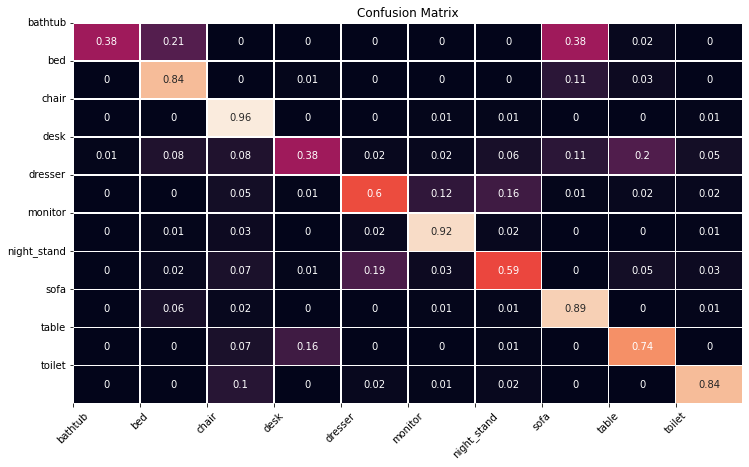

In [8]:
fig=plt.figure(figsize = (12,7))
sns.heatmap(conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names, rotation=0)
plt.title("Confusion Matrix")
        

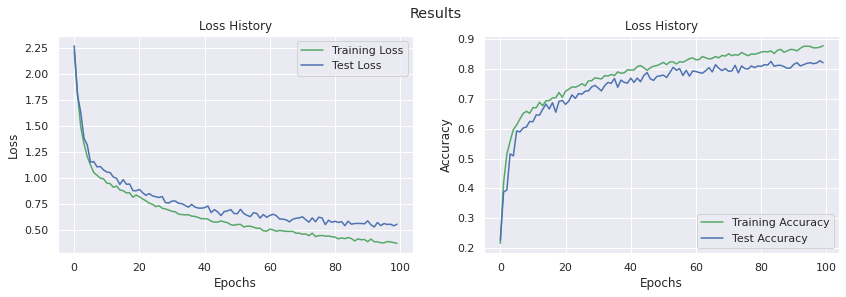

In [9]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
        smoothed_val = w * last + (1 - w) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
        
    return smoothed

eps = range(0, len(history["train_loss"].cpu()))
        
sns.set_theme()
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
fig.suptitle('Results')
       
ax[0].plot(eps, smooth(history["train_loss"].cpu()), 'g', label='Training Loss')
ax[0].plot(eps, smooth(history["test_loss"].cpu()), 'b', label='Test Loss')
ax[0].set_title('Loss History')
ax[0].set(xlabel='Epochs', ylabel='Loss')
ax[0].legend()
        
ax[1].plot(eps, smooth(history["train_acc"].cpu()), 'g', label='Training Accuracy')
ax[1].plot(eps, smooth(history["test_acc"].cpu()), 'b', label='Test Accuracy')
ax[1].set_title('Loss History')
ax[1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1].legend()

In [ ]:
from collections import OrderedDict
class BatchVoxNet(nn.Module):
    def __init__(self):
        super(BatchVoxNet, self).__init__()
        n_classes = 10
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('relu1', torch.nn.ReLU()),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3)),
            ('relu2', torch.nn.ReLU()),
            #('batch2', torch.nn.BatchNorm3d(32)),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        return x

In [ ]:
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm

def blue(x): return '\033[94m' + x + '\033[0m'

train_ds = VoxelDataset2(train=True)
test_ds = VoxelDataset2(train=False)
train_dataloader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(dataset=test_ds, batch_size=32)

pred_conf, y_conf = [], []                                                           

train_loss_history, valid_loss_history = [], []
train_acc_history, valid_acc_history = [], []
train_accuracy = Accuracy(task='multiclass', num_classes=10)
valid_accuracy = Accuracy(task='multiclass', num_classes=10)

model = BatchVoxNet()
opt = SGD(model.parameters(), lr=1e-2, weight_decay = 0)
loss_fn = F.cross_entropy
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
epochs = 100
best_val = np.inf

num_batch = len(train_ds) / 32
print(num_batch)

total_time = time.time()

for epoch in range(epochs):
    t = time.time()

    temp_correct = 0
    temp_testset = 0
    temp_correct_test = 0
    temp_testset_test = 0
    train_loss = []                                                         #track training loss
    test_loss = []
    model.train()
    iterator = tqdm(enumerate(train_dataloader, 0))
    for i, data in iterator:
        inputs, labels = data[0], data[1]
        inputs = inputs.to(device)
        labels = labels.to(device)

        opt.zero_grad()
        pred = model(inputs)  # torch.Size([256, 10])
        loss = F.cross_entropy(pred,labels)
        train_loss.append(loss.cpu().data)
        train_accuracy.update(torch.argmax(pred, 1).cpu(), labels.cpu()) 

        loss.backward()
        opt.step()
        iterator.set_description(f"Train loss: {loss.cpu().data}")
        
        pred_choice = pred.data.max(1)[1]
        correct = pred_choice.eq(labels.data).cpu().sum()
        
        temp_correct += correct.item()
        temp_testset += inputs.size()[0]

    
    with torch.no_grad():
      model.eval()
      for j, sample in tqdm(enumerate(test_dataloader, 0)):    
          inputs_test, labels_test = sample[0], sample[1]
          inputs_test = inputs_test.to(device)
          labels_test = labels_test.to(device)
          inputs_test = inputs_test.float()  # 转float, torch.Size([256, 1, 32, 32, 32])
          
          pred_test = model(inputs_test)
          loss_test = F.cross_entropy(pred_test, labels_test)
          test_loss.append(loss_test.cpu().data)
          valid_accuracy.update(torch.argmax(pred_test, 1).cpu(), labels_test.cpu())
          pred_choice_test = pred_test.data.max(1)[1]

          correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
          pred_conf.append(torch.argmax(pred_test, 1))
          y_conf.append(labels_test)
          
          temp_correct_test += correct_test.item()
          temp_testset_test += inputs_test.size()[0]

    #compute confusion matrix
    a = torch.cat(pred_conf).cpu()
    b = torch.cat(y_conf).cpu()
    confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
    conf_matrix = confmat(a, b)
    conf_matrix = torch.round(conf_matrix, decimals=2)

    # total accuracy over all batches
    total_train_accuracy = train_accuracy.compute()
    total_valid_accuracy = valid_accuracy.compute()
    train_accuracy.reset()
    valid_accuracy.reset()
           
    #track loss and acc for plotting
    train_loss_history.append(torch.mean(torch.tensor(train_loss)))
    valid_loss_history.append(torch.mean(torch.tensor(test_loss)))
    train_acc_history.append(total_train_accuracy)
    valid_acc_history.append(total_valid_accuracy)
    history = {"train_loss": torch.tensor(train_loss_history), "train_acc": torch.tensor(train_acc_history), 
               "test_loss": torch.tensor(valid_loss_history), "test_acc": torch.tensor(valid_acc_history)}

    elapsed_time_epoch = time.time() - t
    tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, epochs)
    tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
    tmp2 = "train-loss: {:4.2f}, train-acc: {:.2%}".format(train_loss_history[epoch], train_acc_history[epoch].item())
    tmp3 = "valid-loss: {:4.2f}, valid-acc: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history[epoch].item())
    print(tmp0, tmp1, tmp2, tmp3, sep="\n")           
    
    #print("epoch %d: train accuracy %f" % (epoch, temp_correct / float(temp_testset)))
    #print("epoch %d: test accuracy %f" % (epoch+1, temp_correct_test / float(temp_testset_test)))

    


total_correct = 0
total_testset = 0

model.eval()
for i, data in tqdm(enumerate(test_dataloader, 0)):
    inputs, labels = data[0], data[1]
    inputs = inputs.to(device)
    labels = labels.to(device)
    inputs = inputs.float()  # 转float, torch.Size([256, 1, 32, 32, 32])

    
    pred = model(inputs)
    pred_choice = pred.data.max(1)[1]
    correct = pred_choice.eq(labels.data).cpu().sum()
    total_correct += correct.item()
    total_testset += inputs.size()[0]

print("final accuracy {}".format(total_correct / float(total_testset)))


124.71875


Train loss: 1.2531027793884277: : 124it [01:16,  1.62it/s]
29it [00:09,  2.92it/s]


epoch:  1 /100
time: 86.65 seconds
train-loss: 1.61, train-acc: 47.81%
valid-loss: 1.47, valid-acc: 46.26%



Train loss: 1.1407716274261475: : 124it [01:15,  1.63it/s]
29it [00:09,  2.91it/s]


epoch:  2 /100
time: 85.94 seconds
train-loss: 1.19, train-acc: 60.21%
valid-loss: 1.24, valid-acc: 55.84%



Train loss: 0.8870738744735718: : 124it [01:16,  1.63it/s]
29it [00:09,  2.93it/s]


epoch:  3 /100
time: 86.13 seconds
train-loss: 0.99, train-acc: 66.63%
valid-loss: 0.98, valid-acc: 66.96%



Train loss: 1.098335862159729: : 124it [01:14,  1.66it/s]
29it [00:10,  2.65it/s]


epoch:  4 /100
time: 85.77 seconds
train-loss: 0.87, train-acc: 71.24%
valid-loss: 0.87, valid-acc: 69.71%



Train loss: 1.4386532306671143: : 124it [01:15,  1.65it/s]
29it [00:10,  2.88it/s]


epoch:  5 /100
time: 85.36 seconds
train-loss: 0.78, train-acc: 74.32%
valid-loss: 0.82, valid-acc: 71.37%



Train loss: 1.013895034790039: : 124it [01:16,  1.62it/s]
29it [00:10,  2.88it/s]


epoch:  6 /100
time: 86.71 seconds
train-loss: 0.72, train-acc: 76.71%
valid-loss: 0.76, valid-acc: 72.91%



Train loss: 0.5788068175315857: : 124it [01:15,  1.65it/s]
29it [00:09,  2.91it/s]


epoch:  7 /100
time: 85.29 seconds
train-loss: 0.67, train-acc: 77.04%
valid-loss: 0.73, valid-acc: 70.59%



Train loss: 0.5548005104064941: : 124it [01:16,  1.62it/s]
29it [00:10,  2.90it/s]


epoch:  8 /100
time: 86.69 seconds
train-loss: 0.65, train-acc: 78.40%
valid-loss: 0.68, valid-acc: 76.87%



Train loss: 0.5426470041275024: : 124it [01:16,  1.63it/s]
29it [00:09,  2.90it/s]


epoch:  9 /100
time: 86.21 seconds
train-loss: 0.62, train-acc: 79.13%
valid-loss: 0.70, valid-acc: 73.35%



Train loss: 0.38112786412239075: : 124it [01:14,  1.66it/s]
29it [00:09,  2.93it/s]


epoch: 10 /100
time: 84.60 seconds
train-loss: 0.60, train-acc: 79.66%
valid-loss: 0.64, valid-acc: 77.64%



Train loss: 0.7342418432235718: : 124it [01:16,  1.63it/s]
29it [00:09,  2.95it/s]


epoch: 11 /100
time: 86.08 seconds
train-loss: 0.57, train-acc: 81.30%
valid-loss: 0.65, valid-acc: 76.10%



Train loss: 0.4369502663612366: : 124it [01:14,  1.66it/s]
29it [00:10,  2.75it/s]


epoch: 12 /100
time: 85.07 seconds
train-loss: 0.56, train-acc: 81.85%
valid-loss: 0.60, valid-acc: 78.96%



Train loss: 0.6575618982315063: : 124it [01:15,  1.64it/s]
29it [00:10,  2.89it/s]


epoch: 13 /100
time: 85.51 seconds
train-loss: 0.52, train-acc: 82.66%
valid-loss: 0.61, valid-acc: 78.41%



Train loss: 0.7097237706184387: : 124it [01:16,  1.63it/s]
29it [00:09,  2.94it/s]


epoch: 14 /100
time: 86.14 seconds
train-loss: 0.53, train-acc: 82.21%
valid-loss: 0.62, valid-acc: 77.75%



Train loss: 0.47648271918296814: : 124it [01:14,  1.66it/s]
29it [00:09,  2.94it/s]


epoch: 15 /100
time: 84.56 seconds
train-loss: 0.51, train-acc: 82.99%
valid-loss: 0.57, valid-acc: 79.63%



Train loss: 0.2728916108608246: : 124it [01:16,  1.63it/s]
29it [00:10,  2.89it/s]


epoch: 16 /100
time: 86.25 seconds
train-loss: 0.50, train-acc: 83.04%
valid-loss: 0.62, valid-acc: 77.64%



Train loss: 0.3246942162513733: : 124it [01:16,  1.63it/s]
29it [00:09,  2.92it/s]


epoch: 17 /100
time: 86.17 seconds
train-loss: 0.48, train-acc: 84.22%
valid-loss: 0.61, valid-acc: 78.08%



Train loss: 0.5188281536102295: : 124it [01:14,  1.66it/s]
29it [00:09,  2.95it/s]


epoch: 18 /100
time: 84.39 seconds
train-loss: 0.47, train-acc: 83.90%
valid-loss: 0.56, valid-acc: 80.51%



Train loss: 0.5508619546890259: : 124it [01:16,  1.63it/s]
29it [00:09,  2.94it/s]


epoch: 19 /100
time: 86.00 seconds
train-loss: 0.45, train-acc: 85.71%
valid-loss: 0.55, valid-acc: 80.40%



Train loss: 0.5192699432373047: : 124it [01:15,  1.63it/s]
29it [00:09,  2.93it/s]


epoch: 20 /100
time: 85.92 seconds
train-loss: 0.44, train-acc: 85.66%
valid-loss: 0.57, valid-acc: 80.40%



Train loss: 0.49536871910095215: : 124it [01:14,  1.66it/s]
29it [00:09,  2.94it/s]


epoch: 21 /100
time: 84.51 seconds
train-loss: 0.44, train-acc: 85.53%
valid-loss: 0.61, valid-acc: 78.08%



Train loss: 0.45977190136909485: : 124it [01:15,  1.63it/s]
29it [00:09,  2.95it/s]


epoch: 22 /100
time: 85.83 seconds
train-loss: 0.44, train-acc: 85.48%
valid-loss: 0.60, valid-acc: 80.18%



Train loss: 0.9048536419868469: : 124it [01:14,  1.66it/s]
29it [00:11,  2.54it/s]


epoch: 23 /100
time: 86.06 seconds
train-loss: 0.42, train-acc: 85.53%
valid-loss: 0.54, valid-acc: 81.39%



Train loss: 0.7113231420516968: : 124it [01:14,  1.66it/s]
29it [00:10,  2.90it/s]


epoch: 24 /100
time: 84.60 seconds
train-loss: 0.41, train-acc: 87.00%
valid-loss: 0.52, valid-acc: 82.38%



Train loss: 0.4702191650867462: : 124it [01:16,  1.62it/s]
29it [00:09,  2.94it/s]


epoch: 25 /100
time: 86.25 seconds
train-loss: 0.41, train-acc: 86.44%
valid-loss: 0.54, valid-acc: 80.95%



Train loss: 0.5765255093574524: : 124it [01:14,  1.66it/s]
29it [00:09,  2.94it/s]


epoch: 26 /100
time: 84.48 seconds
train-loss: 0.42, train-acc: 86.57%
valid-loss: 0.50, valid-acc: 82.27%



Train loss: 0.4075504541397095: : 124it [01:16,  1.63it/s]
29it [00:09,  2.92it/s]


epoch: 27 /100
time: 86.07 seconds
train-loss: 0.39, train-acc: 87.00%
valid-loss: 0.51, valid-acc: 81.61%



Train loss: 0.24951474368572235: : 124it [01:16,  1.63it/s]
29it [00:09,  2.93it/s]


epoch: 28 /100
time: 86.05 seconds
train-loss: 0.39, train-acc: 87.17%
valid-loss: 0.55, valid-acc: 82.16%



Train loss: 0.45243480801582336: : 124it [01:14,  1.66it/s]
29it [00:09,  2.93it/s]


epoch: 29 /100
time: 84.53 seconds
train-loss: 0.38, train-acc: 87.55%
valid-loss: 0.51, valid-acc: 83.04%



Train loss: 0.7161038517951965: : 124it [01:16,  1.63it/s]
29it [00:09,  2.93it/s]


epoch: 30 /100
time: 86.22 seconds
train-loss: 0.37, train-acc: 87.47%
valid-loss: 0.49, valid-acc: 83.59%



Train loss: 0.34676921367645264: : 124it [01:15,  1.63it/s]
29it [00:09,  2.94it/s]


epoch: 31 /100
time: 85.85 seconds
train-loss: 0.36, train-acc: 87.42%
valid-loss: 0.51, valid-acc: 83.04%



Train loss: 0.5471286177635193: : 124it [01:14,  1.66it/s]
29it [00:09,  2.93it/s]


epoch: 32 /100
time: 84.66 seconds
train-loss: 0.34, train-acc: 88.56%
valid-loss: 0.53, valid-acc: 82.82%



Train loss: 0.2812546491622925: : 124it [01:16,  1.62it/s]
29it [00:10,  2.90it/s]


epoch: 33 /100
time: 86.63 seconds
train-loss: 0.36, train-acc: 87.60%
valid-loss: 0.52, valid-acc: 82.71%



Train loss: 0.49017658829689026: : 124it [01:16,  1.63it/s]
29it [00:09,  2.91it/s]


epoch: 34 /100
time: 86.27 seconds
train-loss: 0.35, train-acc: 87.90%
valid-loss: 0.51, valid-acc: 81.06%



Train loss: 0.44291767477989197: : 124it [01:14,  1.66it/s]
29it [00:09,  2.93it/s]


epoch: 35 /100
time: 84.54 seconds
train-loss: 0.35, train-acc: 87.83%
valid-loss: 0.51, valid-acc: 83.81%



Train loss: 0.5387308597564697: : 124it [01:16,  1.63it/s]
29it [00:09,  2.94it/s]


epoch: 36 /100
time: 86.06 seconds
train-loss: 0.35, train-acc: 87.63%
valid-loss: 0.50, valid-acc: 81.94%



Train loss: 0.2443668693304062: : 124it [01:16,  1.63it/s]
29it [00:09,  2.92it/s]


epoch: 37 /100
time: 86.03 seconds
train-loss: 0.33, train-acc: 88.23%
valid-loss: 0.53, valid-acc: 82.93%



Train loss: 0.22115696966648102: : 124it [01:14,  1.66it/s]
29it [00:09,  2.94it/s]


epoch: 38 /100
time: 84.61 seconds
train-loss: 0.33, train-acc: 88.79%
valid-loss: 0.48, valid-acc: 82.27%



Train loss: 0.23511679470539093: : 124it [01:16,  1.63it/s]
29it [00:09,  2.93it/s]


epoch: 39 /100
time: 86.09 seconds
train-loss: 0.33, train-acc: 89.06%
valid-loss: 0.51, valid-acc: 83.26%



Train loss: 0.3067035973072052: : 124it [01:16,  1.63it/s]
29it [00:09,  2.93it/s]


epoch: 40 /100
time: 85.98 seconds
train-loss: 0.33, train-acc: 88.99%
valid-loss: 0.50, valid-acc: 83.92%



Train loss: 0.3058783710002899: : 124it [01:14,  1.66it/s]
29it [00:09,  2.91it/s]


epoch: 41 /100
time: 84.47 seconds
train-loss: 0.31, train-acc: 89.54%
valid-loss: 0.47, valid-acc: 85.13%



Train loss: 0.3849596679210663: : 124it [01:14,  1.66it/s]
29it [00:09,  2.95it/s]


epoch: 42 /100
time: 84.35 seconds
train-loss: 0.31, train-acc: 88.71%
valid-loss: 0.51, valid-acc: 83.26%



Train loss: 0.1455397754907608: : 124it [01:14,  1.66it/s]
29it [00:09,  2.95it/s]


epoch: 43 /100
time: 84.47 seconds
train-loss: 0.31, train-acc: 89.52%
valid-loss: 0.49, valid-acc: 82.27%



Train loss: 0.625764787197113: : 124it [01:14,  1.66it/s]
29it [00:09,  2.93it/s]


epoch: 44 /100
time: 84.51 seconds
train-loss: 0.30, train-acc: 89.72%
valid-loss: 0.52, valid-acc: 83.26%



Train loss: 0.17677849531173706: : 124it [01:14,  1.66it/s]
29it [00:09,  2.94it/s]


epoch: 45 /100
time: 84.43 seconds
train-loss: 0.31, train-acc: 88.96%
valid-loss: 0.47, valid-acc: 82.38%



Train loss: 0.28785252571105957: : 124it [01:14,  1.66it/s]
29it [00:09,  2.92it/s]


epoch: 46 /100
time: 84.88 seconds
train-loss: 0.31, train-acc: 89.01%
valid-loss: 0.53, valid-acc: 83.26%



Train loss: 0.3160596787929535: : 124it [01:14,  1.65it/s]
29it [00:09,  2.92it/s]


epoch: 47 /100
time: 84.92 seconds
train-loss: 0.31, train-acc: 89.14%
valid-loss: 0.48, valid-acc: 84.03%



Train loss: 0.33771124482154846: : 124it [01:15,  1.65it/s]
29it [00:09,  2.93it/s]


epoch: 48 /100
time: 84.93 seconds
train-loss: 0.31, train-acc: 89.47%
valid-loss: 0.47, valid-acc: 84.03%



Train loss: 0.5733148455619812: : 124it [01:14,  1.66it/s]
29it [00:09,  2.93it/s]


epoch: 49 /100
time: 84.75 seconds
train-loss: 0.29, train-acc: 90.02%
valid-loss: 0.45, valid-acc: 84.80%



Train loss: 0.25970908999443054: : 124it [01:14,  1.65it/s]
29it [00:09,  2.91it/s]


epoch: 50 /100
time: 84.96 seconds
train-loss: 0.29, train-acc: 89.44%
valid-loss: 0.45, valid-acc: 84.80%



Train loss: 0.2080465406179428: : 124it [01:14,  1.65it/s]
29it [00:10,  2.90it/s]


epoch: 51 /100
time: 84.97 seconds
train-loss: 0.29, train-acc: 89.67%
valid-loss: 0.46, valid-acc: 83.81%



Train loss: 0.23436976969242096: : 124it [01:14,  1.66it/s]
29it [00:09,  2.91it/s]


epoch: 52 /100
time: 84.91 seconds
train-loss: 0.28, train-acc: 89.49%
valid-loss: 0.48, valid-acc: 84.91%



Train loss: 0.5688148736953735: : 124it [01:15,  1.64it/s]
29it [00:10,  2.90it/s]


epoch: 53 /100
time: 85.43 seconds
train-loss: 0.29, train-acc: 89.62%
valid-loss: 0.47, valid-acc: 83.81%



Train loss: 0.248618945479393: : 124it [01:14,  1.65it/s]
29it [00:09,  2.90it/s]


epoch: 54 /100
time: 85.01 seconds
train-loss: 0.27, train-acc: 90.68%
valid-loss: 0.45, valid-acc: 85.35%



Train loss: 0.17564161121845245: : 124it [01:15,  1.65it/s]
29it [00:09,  2.92it/s]


epoch: 55 /100
time: 84.98 seconds
train-loss: 0.28, train-acc: 90.55%
valid-loss: 0.48, valid-acc: 83.48%



Train loss: 0.051307257264852524: : 124it [01:15,  1.65it/s]
29it [00:09,  2.93it/s]


epoch: 56 /100
time: 85.00 seconds
train-loss: 0.29, train-acc: 90.17%
valid-loss: 0.45, valid-acc: 85.35%



Train loss: 0.4661206603050232: : 124it [01:15,  1.65it/s]
29it [00:09,  2.93it/s]


epoch: 57 /100
time: 84.99 seconds
train-loss: 0.26, train-acc: 90.93%
valid-loss: 0.43, valid-acc: 85.79%



Train loss: 0.24766050279140472: : 124it [01:14,  1.66it/s]
29it [00:10,  2.87it/s]


epoch: 58 /100
time: 84.87 seconds
train-loss: 0.27, train-acc: 90.57%
valid-loss: 0.47, valid-acc: 84.36%



Train loss: 0.5221536755561829: : 124it [01:14,  1.66it/s]
29it [00:09,  2.94it/s]


epoch: 59 /100
time: 84.74 seconds
train-loss: 0.27, train-acc: 90.52%
valid-loss: 0.46, valid-acc: 84.36%



Train loss: 0.41498780250549316: : 124it [01:14,  1.66it/s]
29it [00:09,  2.94it/s]


epoch: 60 /100
time: 84.73 seconds
train-loss: 0.27, train-acc: 90.32%
valid-loss: 0.45, valid-acc: 84.36%



Train loss: 0.26009315252304077: : 124it [01:14,  1.66it/s]
29it [00:09,  2.92it/s]


epoch: 61 /100
time: 84.82 seconds
train-loss: 0.27, train-acc: 90.62%
valid-loss: 0.47, valid-acc: 86.01%



Train loss: 0.31157565116882324: : 124it [01:14,  1.66it/s]
29it [00:09,  2.92it/s]


epoch: 62 /100
time: 84.74 seconds
train-loss: 0.26, train-acc: 90.93%
valid-loss: 0.47, valid-acc: 85.35%



Train loss: 0.3052690923213959: : 124it [01:14,  1.66it/s]
29it [00:09,  2.92it/s]


epoch: 63 /100
time: 84.79 seconds
train-loss: 0.26, train-acc: 91.08%
valid-loss: 0.50, valid-acc: 84.36%



Train loss: 0.1168251484632492: : 124it [01:14,  1.66it/s]
29it [00:10,  2.88it/s]


epoch: 64 /100
time: 85.03 seconds
train-loss: 0.25, train-acc: 91.13%
valid-loss: 0.47, valid-acc: 83.48%



Train loss: 0.1621626764535904: : 124it [01:14,  1.66it/s]
29it [00:09,  2.93it/s]


epoch: 65 /100
time: 84.65 seconds
train-loss: 0.26, train-acc: 91.03%
valid-loss: 0.45, valid-acc: 84.58%



Train loss: 0.23077628016471863: : 124it [01:14,  1.66it/s]
29it [00:09,  2.93it/s]


epoch: 66 /100
time: 84.78 seconds
train-loss: 0.24, train-acc: 91.20%
valid-loss: 0.53, valid-acc: 83.70%



Train loss: 0.3545244038105011: : 124it [01:14,  1.66it/s]
29it [00:09,  2.92it/s]


epoch: 67 /100
time: 84.69 seconds
train-loss: 0.25, train-acc: 90.98%
valid-loss: 0.48, valid-acc: 84.03%



Train loss: 0.2658758759498596: : 124it [01:14,  1.66it/s]
29it [00:09,  2.91it/s]


epoch: 68 /100
time: 84.82 seconds
train-loss: 0.24, train-acc: 91.46%
valid-loss: 0.56, valid-acc: 81.06%



Train loss: 0.39469555020332336: : 124it [01:14,  1.66it/s]
29it [00:09,  2.92it/s]


epoch: 69 /100
time: 84.82 seconds
train-loss: 0.24, train-acc: 91.83%
valid-loss: 0.44, valid-acc: 85.68%



Train loss: 0.4836823344230652: : 124it [01:14,  1.66it/s]
29it [00:09,  2.92it/s]


epoch: 70 /100
time: 84.69 seconds
train-loss: 0.25, train-acc: 90.83%
valid-loss: 0.46, valid-acc: 85.90%



Train loss: 0.25888100266456604: : 124it [01:14,  1.66it/s]
29it [00:09,  2.92it/s]


epoch: 71 /100
time: 84.67 seconds
train-loss: 0.23, train-acc: 91.63%
valid-loss: 0.48, valid-acc: 85.35%



Train loss: 0.23097938299179077: : 124it [01:14,  1.66it/s]
29it [00:09,  2.93it/s]


epoch: 72 /100
time: 84.74 seconds
train-loss: 0.23, train-acc: 91.94%
valid-loss: 0.47, valid-acc: 85.35%



Train loss: 0.17281970381736755: : 124it [01:14,  1.66it/s]
29it [00:09,  2.95it/s]


epoch: 73 /100
time: 84.34 seconds
train-loss: 0.24, train-acc: 91.48%
valid-loss: 0.49, valid-acc: 84.14%



Train loss: 0.303986132144928: : 124it [01:14,  1.66it/s]
29it [00:09,  2.94it/s]


epoch: 74 /100
time: 84.39 seconds
train-loss: 0.23, train-acc: 91.58%
valid-loss: 0.44, valid-acc: 86.56%



Train loss: 0.20856653153896332: : 124it [01:14,  1.66it/s]
29it [00:09,  2.93it/s]


epoch: 75 /100
time: 84.46 seconds
train-loss: 0.23, train-acc: 91.83%
valid-loss: 0.47, valid-acc: 84.58%



Train loss: 0.13195109367370605: : 124it [01:14,  1.66it/s]
29it [00:09,  2.94it/s]


epoch: 76 /100
time: 84.50 seconds
train-loss: 0.23, train-acc: 91.76%
valid-loss: 0.46, valid-acc: 84.47%



Train loss: 0.1393601894378662: : 124it [01:14,  1.66it/s]
29it [00:09,  2.94it/s]


epoch: 77 /100
time: 84.49 seconds
train-loss: 0.21, train-acc: 92.52%
valid-loss: 0.46, valid-acc: 85.13%



Train loss: 0.1896858960390091: : 124it [01:14,  1.67it/s]
29it [00:09,  2.95it/s]


epoch: 78 /100
time: 84.27 seconds
train-loss: 0.22, train-acc: 91.91%
valid-loss: 0.45, valid-acc: 86.01%



Train loss: 0.396287739276886: : 124it [01:14,  1.67it/s]
29it [00:09,  2.94it/s]


epoch: 79 /100
time: 84.24 seconds
train-loss: 0.23, train-acc: 91.86%
valid-loss: 0.44, valid-acc: 85.79%



Train loss: 0.3465014398097992: : 124it [01:14,  1.66it/s]
29it [00:09,  2.94it/s]


epoch: 80 /100
time: 84.42 seconds
train-loss: 0.23, train-acc: 92.11%
valid-loss: 0.44, valid-acc: 85.57%



Train loss: 0.35285523533821106: : 124it [01:14,  1.67it/s]
29it [00:09,  2.92it/s]


epoch: 81 /100
time: 84.42 seconds
train-loss: 0.22, train-acc: 92.09%
valid-loss: 0.47, valid-acc: 85.68%



Train loss: 0.27695590257644653: : 124it [01:14,  1.66it/s]
29it [00:09,  2.93it/s]


epoch: 82 /100
time: 84.42 seconds
train-loss: 0.22, train-acc: 92.14%
valid-loss: 0.45, valid-acc: 86.56%



Train loss: 0.15894152224063873: : 124it [01:14,  1.66it/s]
29it [00:09,  2.94it/s]


epoch: 83 /100
time: 84.45 seconds
train-loss: 0.21, train-acc: 92.72%
valid-loss: 0.46, valid-acc: 85.79%



Train loss: 0.31962478160858154: : 124it [01:14,  1.66it/s]
29it [00:09,  2.94it/s]


epoch: 84 /100
time: 84.45 seconds
train-loss: 0.21, train-acc: 92.34%
valid-loss: 0.43, valid-acc: 86.56%



Train loss: 0.05545513704419136: : 124it [01:14,  1.66it/s]
29it [00:09,  2.91it/s]


epoch: 85 /100
time: 84.59 seconds
train-loss: 0.21, train-acc: 92.62%
valid-loss: 0.46, valid-acc: 86.78%



Train loss: 0.0951540544629097: : 124it [01:14,  1.66it/s]
29it [00:09,  2.95it/s]


epoch: 86 /100
time: 84.37 seconds
train-loss: 0.21, train-acc: 92.57%
valid-loss: 0.47, valid-acc: 85.46%



Train loss: 0.1679050326347351: : 124it [01:14,  1.66it/s]
29it [00:09,  2.92it/s]


epoch: 87 /100
time: 84.54 seconds
train-loss: 0.21, train-acc: 92.16%
valid-loss: 0.46, valid-acc: 84.80%



Train loss: 0.36707639694213867: : 124it [01:14,  1.67it/s]
29it [00:09,  2.95it/s]


epoch: 88 /100
time: 84.03 seconds
train-loss: 0.22, train-acc: 92.01%
valid-loss: 0.45, valid-acc: 85.46%



Train loss: 0.11666408181190491: : 124it [01:14,  1.67it/s]
29it [00:09,  2.94it/s]


epoch: 89 /100
time: 84.24 seconds
train-loss: 0.21, train-acc: 92.79%
valid-loss: 0.45, valid-acc: 86.45%



Train loss: 0.22423064708709717: : 124it [01:14,  1.67it/s]
29it [00:09,  2.94it/s]


epoch: 90 /100
time: 84.30 seconds
train-loss: 0.21, train-acc: 92.04%
valid-loss: 0.43, valid-acc: 87.00%



Train loss: 0.16807526350021362: : 124it [01:14,  1.67it/s]
29it [00:09,  2.94it/s]


epoch: 91 /100
time: 84.30 seconds
train-loss: 0.20, train-acc: 93.27%
valid-loss: 0.46, valid-acc: 86.34%



Train loss: 0.2792293131351471: : 124it [01:13,  1.68it/s]
29it [00:09,  2.96it/s]


epoch: 92 /100
time: 83.84 seconds
train-loss: 0.21, train-acc: 92.39%
valid-loss: 0.44, valid-acc: 85.13%



Train loss: 0.18335112929344177: : 124it [01:13,  1.68it/s]
29it [00:09,  2.95it/s]


epoch: 93 /100
time: 83.84 seconds
train-loss: 0.20, train-acc: 92.84%
valid-loss: 0.45, valid-acc: 85.57%



Train loss: 0.09810027480125427: : 124it [01:14,  1.67it/s]
29it [00:09,  2.94it/s]


epoch: 94 /100
time: 84.25 seconds
train-loss: 0.19, train-acc: 93.27%
valid-loss: 0.47, valid-acc: 86.34%



Train loss: 0.27874261140823364: : 124it [01:14,  1.67it/s]
29it [00:09,  2.97it/s]


epoch: 95 /100
time: 84.27 seconds
train-loss: 0.21, train-acc: 92.21%
valid-loss: 0.46, valid-acc: 86.01%



Train loss: 0.17574642598628998: : 124it [01:14,  1.67it/s]
29it [00:09,  2.94it/s]


epoch: 96 /100
time: 84.14 seconds
train-loss: 0.19, train-acc: 92.87%
valid-loss: 0.46, valid-acc: 85.68%



Train loss: 0.23333048820495605: : 124it [01:14,  1.66it/s]
29it [00:09,  2.95it/s]


epoch: 97 /100
time: 84.41 seconds
train-loss: 0.20, train-acc: 93.12%
valid-loss: 0.46, valid-acc: 85.79%



Train loss: 0.1919616460800171: : 124it [01:14,  1.66it/s]
29it [00:09,  2.90it/s]


epoch: 98 /100
time: 84.57 seconds
train-loss: 0.19, train-acc: 93.02%
valid-loss: 0.43, valid-acc: 86.78%



Train loss: 0.22171421349048615: : 124it [01:14,  1.67it/s]
29it [00:10,  2.89it/s]


epoch: 99 /100
time: 84.49 seconds
train-loss: 0.19, train-acc: 93.37%
valid-loss: 0.40, valid-acc: 86.67%



Train loss: 0.4175178110599518: : 124it [01:14,  1.67it/s]
29it [00:09,  2.96it/s]


epoch:100 /100
time: 84.20 seconds
train-loss: 0.20, train-acc: 92.94%
valid-loss: 0.42, valid-acc: 88.22%



29it [00:09,  2.96it/s]

final accuracy 0.8689427312775331


Text(0.5, 1.0, 'Confusion Matrix')

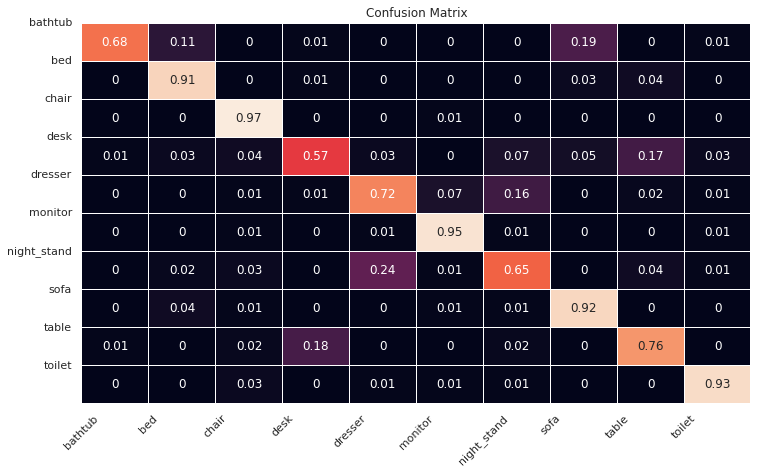

In [ ]:
fig=plt.figure(figsize = (12,7))
sns.heatmap(conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names, rotation=0)
plt.title("Confusion Matrix")

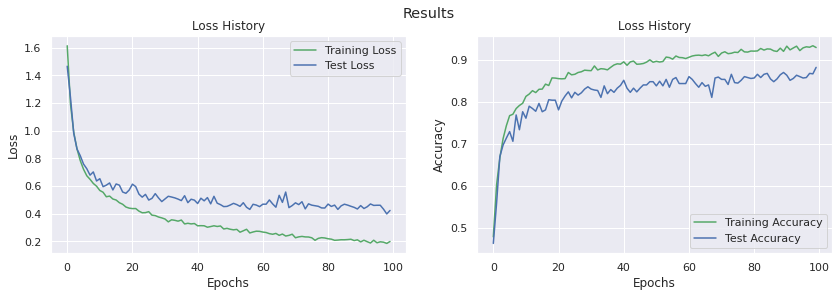

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
        smoothed_val = w * last + (1 - w) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
        
    return smoothed

eps = range(0, len(history["train_loss"].cpu()))
        
sns.set_theme()
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
fig.suptitle('Results')
       
ax[0].plot(eps, smooth(history["train_loss"].cpu()), 'g', label='Training Loss')
ax[0].plot(eps, smooth(history["test_loss"].cpu()), 'b', label='Test Loss')
ax[0].set_title('Loss History')
ax[0].set(xlabel='Epochs', ylabel='Loss')
ax[0].legend()
        
ax[1].plot(eps, smooth(history["train_acc"].cpu()), 'g', label='Training Accuracy')
ax[1].plot(eps, smooth(history["test_acc"].cpu()), 'b', label='Test Accuracy')
ax[1].set_title('Loss History')
ax[1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1].legend()